# Image Generation with IP-Adapter XL (SDXL)

This notebook demonstrates how to use the DEGIS package to:
1. Load trained color head models
2. Set up IP-Adapter XL with ControlNet for high-quality image generation
3. Generate images using color and layout control with SDXL

Based on the ablation notebook but using IP-Adapter XL for higher quality results.


## 1. Setup and Install Dependencies


In [1]:
# # Install IP-Adapter and dependencies
# %pip uninstall -y ip-adapter diffusers
# %pip install --no-cache-dir git+https://github.com/Ahmed-Sherif-ASA/IP-Adapter@main
# %pip install diffusers


## 2. Imports and Setup


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms
from IPython.display import display
import os
import glob

# Import the DEGIS package
import degis
from degis.data.dataset import UnifiedImageDataset
# from degis.config import csv_path, embeddings_path, colour_path, precomputed_adimagenet_edge_maps_path

# Import IP-Adapter XL
import ip_adapter
from ip_adapter import IPAdapterXL
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 3. Load Data and Models


In [3]:
csv_path = "/data/thesis/laion_5m_manifest.csv"
embeddings_path = "/data/thesis/models/hf_xl_laion_5m_embeddings.npy" # || YOUR_CUSTOM_PATH
colour_path = "/data/thesis/data/laion_5m_color_histograms_rgb_512.npy" # options: COLOR_HIST_PATH_LAB_514 || COLOR_HIST_PATH_RGB || YOUR_CUSTOM_PATH
colour_head_checkpoint_path = "/data/degis/runs/laion_5m_rgb512_tk20_b4096-20250904-234241/best_color_head_tmp.pth" # || YOUR_CUSTOM_PATH
precomputed_adimagenet_edge_maps_path = "/data/thesis/data/adimagenet_edge_maps.npy" # || YOUR_CUSTOM_PATH


# ip_ckpt = "/data/thesis/models/ip-adapter_sd15.bin"
image_encoder_path = "laion/CLIP-ViT-bigG-14-laion2B-39B-b160k"
controlnet_id = "diffusers/controlnet-canny-sdxl-1.0"
# stable_diffusion_model_id = "runwayml/stable-diffusion-v1-5"

In [4]:
# Load datasets
df = pd.read_csv(csv_path)
colour_dataset = UnifiedImageDataset(
    df.rename(columns={"local_path": "file_path"}),
    mode="file_df",
    size=(224, 224),
    subset_ratio=1.0
)

# Load precomputed data
embeddings = np.load(embeddings_path, mmap_mode="r").astype(np.float32, copy=False)
histograms = np.load(colour_path, mmap_mode="r").astype(np.float32, copy=False)
edge_maps = np.load(precomputed_adimagenet_edge_maps_path, mmap_mode="r")

print(f"Loaded embeddings: {embeddings.shape}")
print(f"Loaded histograms: {histograms.shape}")
print(f"Loaded edge maps: {edge_maps.shape}")

# Load trained color head
color_head = degis.load_trained_color_head(
    checkpoint_path=colour_head_checkpoint_path,
    clip_dim=embeddings.shape[1],
    hist_dim=histograms.shape[1],
    device=device
)
print("✓ Color head loaded successfully")


Loaded embeddings: (3336240, 1280)
Loaded histograms: (3336240, 512)
Loaded edge maps: (2080, 50176)
✓ Color head loaded successfully


## 4. Setup IP-Adapter XL Pipeline


In [5]:
# Setup cache directory
HF_CACHE = "/data/hf-cache" if os.path.exists("/data") else "./hf-cache"
os.makedirs(HF_CACHE, exist_ok=True)

os.environ["HF_HOME"] = HF_CACHE
os.environ["HUGGINGFACE_HUB_CACHE"] = os.path.join(HF_CACHE, "hub")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(HF_CACHE, "transformers")
os.environ["DIFFUSERS_CACHE"] = os.path.join(HF_CACHE, "diffusers")
os.environ["TORCH_HOME"] = os.path.join(HF_CACHE, "torch")

print(f"Using cache directory: {HF_CACHE}")

# Create IP-Adapter XL generator
generator = degis.IPAdapterXLGenerator(device=device)

# Setup the pipeline
generator.setup_pipeline(
    model_id="stabilityai/stable-diffusion-xl-base-1.0",
    controlnet_id=controlnet_id,
    ip_ckpt=None,  # Update path as needed
    image_encoder_path=image_encoder_path,
    cache_dir=HF_CACHE,
    torch_dtype=torch.float16,
)

print("✓ IP-Adapter XL pipeline setup complete")


Using cache directory: /data/hf-cache


Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLControlNetPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

IP-Adapter sdxl checkpoint not found at h94/IP-Adapter
✓ Downloaded IP-Adapter sdxl checkpoint


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ IP-Adapter XL pipeline setup complete


## 5. Image Generation Functions


In [6]:
def generate_from_dataset_id_xl(
    colour_index: int,
    layout_index: int,
    prompt: str = "a cat playing with a ball",
    guidance_scale: float = 6.5,
    steps: int = 40,
    controlnet_conditioning_scale: float = 0.8,
    num_samples: int = 1,
    attn_ip_scale: float = 0.8,
    text_token_scale: float = 1.0,
    ip_token_scale: float = None,
    ip_uncond_scale: float = 0.0,
    zero_ip_in_uncond: bool = True,
):
    """Generate images using IP-Adapter XL with advanced controls."""
    
    # Get original image for display
    img_t, _ = colour_dataset[colour_index]
    pil_img = transforms.ToPILImage()(img_t)
    
    # Get CLIP embedding and compute color embedding
    z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)
    color_embedding = degis.get_color_embedding(color_head, z_clip)
    
    # Create control image from edge data
    control_image = degis.create_edge_control_image(edge_maps[layout_index], size=512)
    
    # Generate images with IP-Adapter XL
    images = generator.generate(
        color_embedding=color_embedding,
        control_image=control_image,
        prompt=prompt,
        negative_prompt=(
            "monochrome, lowres, bad anatomy, worst quality, low quality, blurry, "
            "sketch, cartoon, drawing, anime:1.4, comic, illustration, posterized, "
            "mosaic, stained glass, abstract, surreal, psychedelic, trippy, texture artifact, "
            "embroidery, knitted, painting, oversaturated, unrealistic, bad shading"
        ),
        num_samples=num_samples,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        # IP-Adapter XL specific parameters
        attn_ip_scale=attn_ip_scale,
        text_token_scale=text_token_scale,
        ip_token_scale=ip_token_scale,
        ip_uncond_scale=ip_uncond_scale,
        zero_ip_in_uncond=zero_ip_in_uncond,
    )
    
    # Display results
    comparison = degis.display_comparison_grid(
        original=pil_img,
        control=control_image,
        generated=images,
        cols=3
    )
    display(comparison)
    
    return images

print("✓ IP-Adapter XL generation function defined")


✓ IP-Adapter XL generation function defined


## 6. Generate High-Quality Images


Generating images with IP-Adapter XL (SDXL)...


/tmp/ipykernel_911090/757691469.py:22: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)


  0%|          | 0/40 [00:00<?, ?it/s]

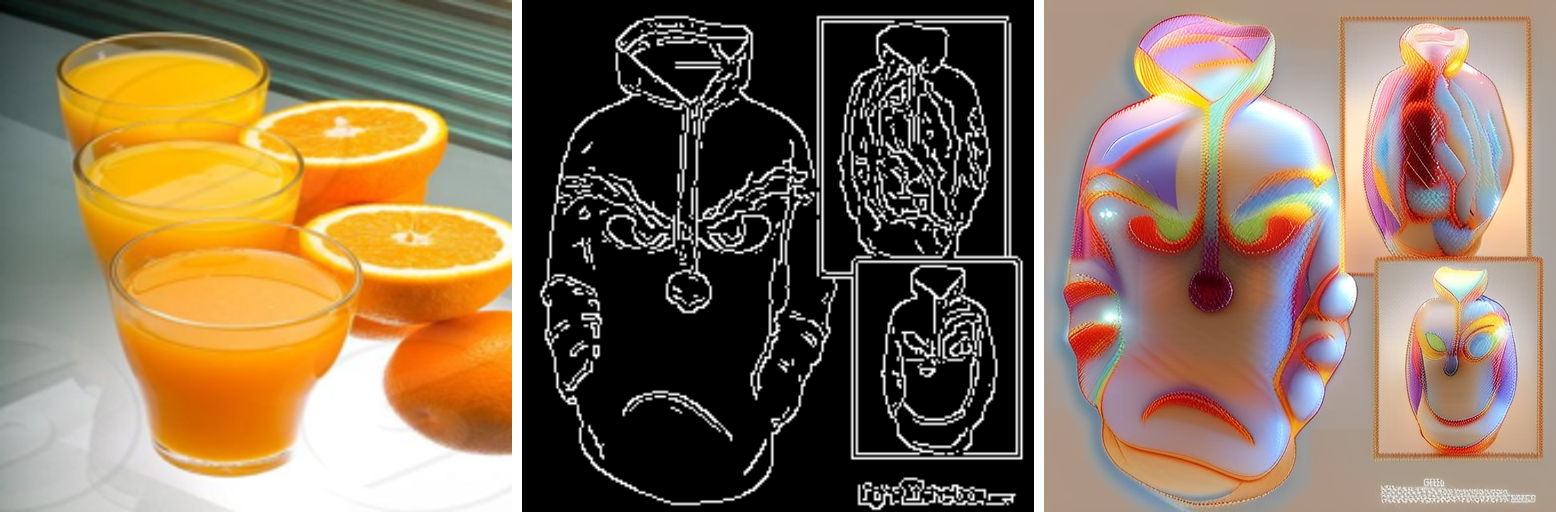

  0%|          | 0/50 [00:00<?, ?it/s]

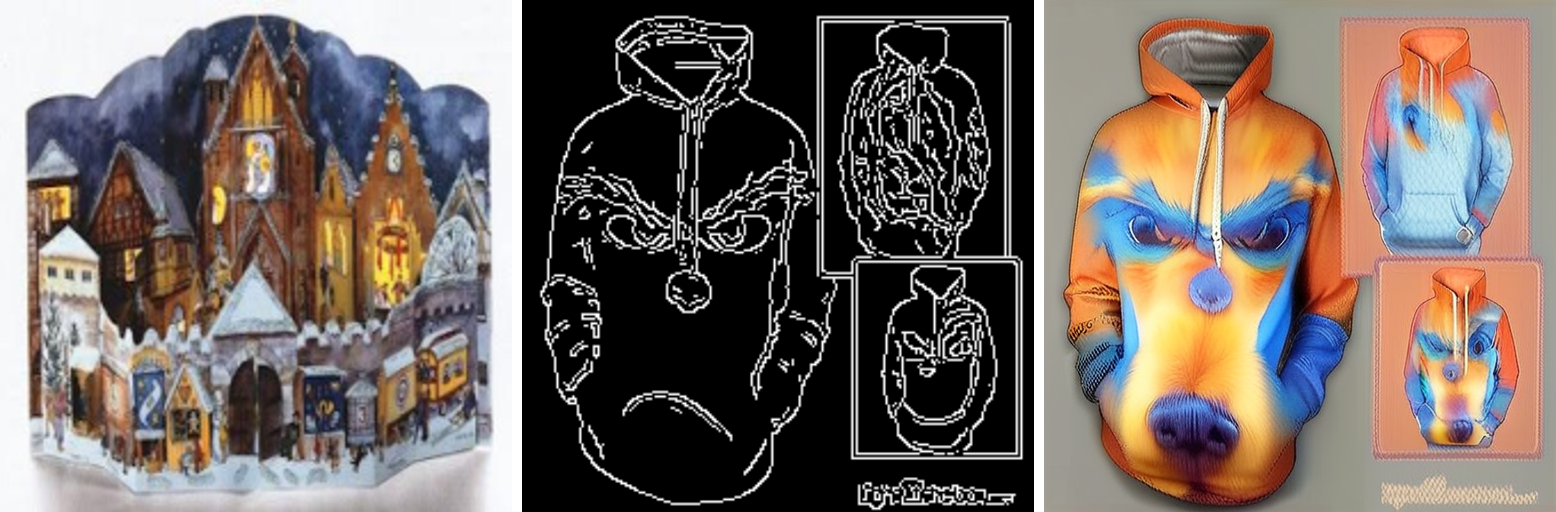

  0%|          | 0/60 [00:00<?, ?it/s]

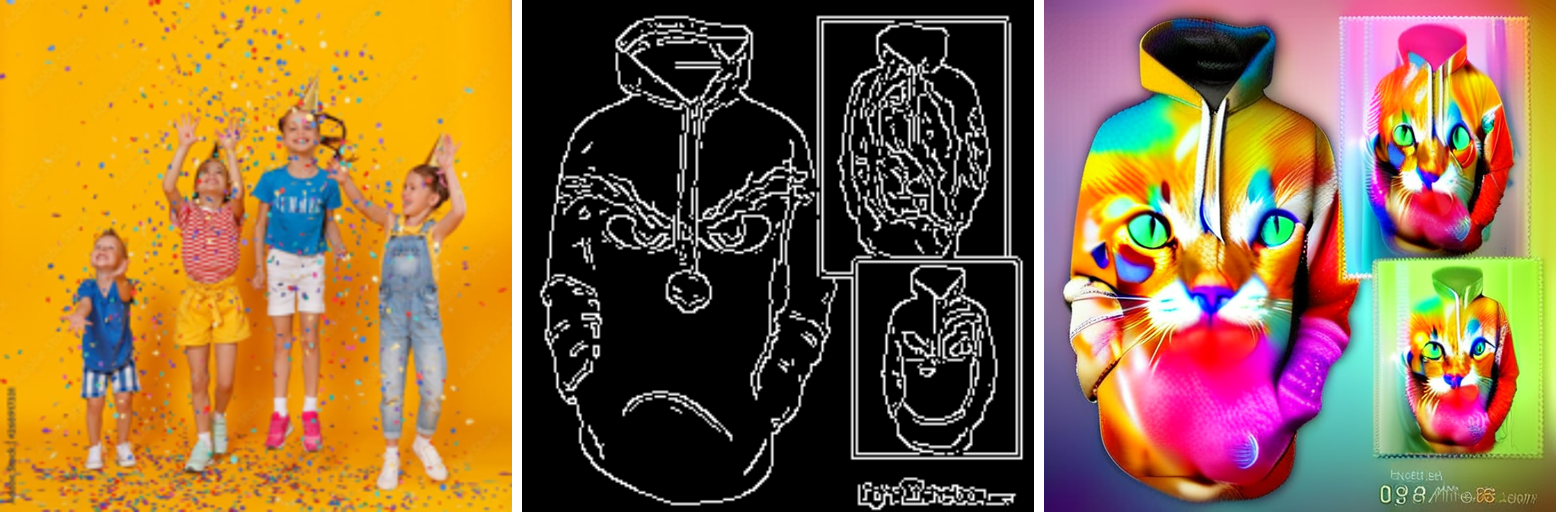

✓ High-quality image generation complete!


In [7]:
# Generate high-quality images with IP-Adapter XL
print("Generating images with IP-Adapter XL (SDXL)...")

# Example 1: Cat with ball (high quality)
images1 = generate_from_dataset_id_xl(
    colour_index=1000,
    layout_index=33,
    prompt="a cat playing with a ball, high quality, detailed",
    guidance_scale=6.5,
    steps=40,
    controlnet_conditioning_scale=0.8,
    num_samples=1,
    attn_ip_scale=0.8,
    text_token_scale=1.0,
    ip_token_scale=0.5,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

# Example 2: Dog on hoodie (artistic style)
images2 = generate_from_dataset_id_xl(
    colour_index=1008,
    layout_index=33,
    prompt="a dog on the hoodie, artistic style, professional photography",
    guidance_scale=7.5,
    steps=50,
    controlnet_conditioning_scale=0.9,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.1,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

# Example 3: Creative composition
images3 = generate_from_dataset_id_xl(
    colour_index=1003,
    layout_index=33,
    prompt="A cat on the hoodie, digital art, vibrant colors, masterpiece",
    guidance_scale=8.0,
    steps=60,
    controlnet_conditioning_scale=0.7,
    num_samples=1,
    attn_ip_scale=0.7,
    text_token_scale=1.2,
    ip_token_scale=0.6,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

print("✓ High-quality image generation complete!")


In [25]:
from degis.features.color_histograms import compute_color_histogram
import geomloss

def calculate_emd_distance_topk(hist1: np.ndarray, hist2: np.ndarray, top_k: int = 20, blur: float = 0.01) -> float:
    """
    Calculate Earth Mover's Distance between top-k histogram values using Sinkhorn algorithm.
    
    Args:
        hist1: First histogram (normalized)
        hist2: Second histogram (normalized)
        top_k: Number of top histogram values to consider
        blur: Blur parameter for Sinkhorn algorithm
        
    Returns:
        EMD distance value
    """
    # Get top-k indices for both histograms
    top_indices_1 = np.argsort(hist1)[-top_k:]
    top_indices_2 = np.argsort(hist2)[-top_k:]
    
    # Get unique indices (union of both top-k sets)
    unique_indices = np.union1d(top_indices_1, top_indices_2)
    
    # Extract top-k values and normalize
    h1_topk = hist1[unique_indices]
    h2_topk = hist2[unique_indices]
    
    # Normalize to sum to 1
    h1_topk = h1_topk / (h1_topk.sum() + 1e-8)
    h2_topk = h2_topk / (h2_topk.sum() + 1e-8)
    
    # Convert to torch tensors and add batch dimension
    h1 = torch.tensor(h1_topk, dtype=torch.float32).unsqueeze(0)
    h2 = torch.tensor(h2_topk, dtype=torch.float32).unsqueeze(0)
    
    # Calculate EMD using Sinkhorn
    loss = geomloss.SamplesLoss("sinkhorn", p=2, blur=blur, backend="tensorized")
    emd = loss(h1, h2).item()
    
    return emd

def generate_from_dataset_id_xl_with_emd(
    colour_index: int,
    layout_index: int,
    prompt: str = "a cat playing with a ball",
    target_emd_threshold: float = 0.1,
    max_attempts: int = 20,
    top_k: int = 20,  # New parameter for top-k EMD
    guidance_scale: float = 6.5,
    steps: int = 40,
    controlnet_conditioning_scale: float = 0.8,
    num_samples: int = 1,
    attn_ip_scale: float = 0.8,
    text_token_scale: float = 1.0,
    ip_token_scale: float = None,
    ip_uncond_scale: float = 0.0,
    zero_ip_in_uncond: bool = True,
):
    """Generate images using IP-Adapter XL with EMD constraint on top-k histogram values."""
    
    # Get original image for display
    img_t, _ = colour_dataset[colour_index]
    pil_img = transforms.ToPILImage()(img_t)
    
    # Get CLIP embedding and compute color embedding
    z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)
    color_embedding = degis.get_color_embedding(color_head, z_clip)
    
    # Get original histogram for EMD comparison
    original_histogram = histograms[colour_index]
    
    # Create control image from edge data
    control_image = degis.create_edge_control_image(edge_maps[layout_index], size=512)
    
    # EMD-constrained generation
    best_images = None
    best_emd = float('inf')
    attempts_made = 0
    
    print(f"Generating with EMD constraint (target: {target_emd_threshold:.3f})")
    print(f"Using prompt: '{prompt}'")
    print(f"Max attempts: {max_attempts}")
    print(f"EMD calculation: top-{top_k} histogram values")
    print("-" * 50)
    
    for attempt in range(max_attempts):
        # Generate images with IP-Adapter XL
        images = generator.generate(
            color_embedding=color_embedding,
            control_image=control_image,
            prompt=prompt,
            negative_prompt=(
                "monochrome, lowres, bad anatomy, worst quality, low quality, blurry, "
                "sketch, cartoon, drawing, anime:1.4, comic, illustration, posterized, "
                "mosaic, stained glass, abstract, surreal, psychedelic, trippy, texture artifact, "
                "embroidery, knitted, painting, oversaturated, unrealistic, bad shading"
            ),
            num_samples=num_samples,
            guidance_scale=guidance_scale,
            num_inference_steps=steps,
            controlnet_conditioning_scale=controlnet_conditioning_scale,
            # IP-Adapter XL specific parameters
            attn_ip_scale=attn_ip_scale,
            text_token_scale=text_token_scale,
            ip_token_scale=ip_token_scale,
            ip_uncond_scale=ip_uncond_scale,
            zero_ip_in_uncond=zero_ip_in_uncond,
        )
        
        # Calculate histogram for generated image
        generated_hist = compute_color_histogram(images[0], bins=8)
        
        # Calculate EMD distance using top-k values
        emd_distance = calculate_emd_distance_topk(original_histogram, generated_hist, top_k=top_k, blur=0.01)
        
        attempts_made += 1
        
        print(f"Attempt {attempt + 1:2d}: EMD = {emd_distance:.4f}", end="")
        
        # Check if this is the best result so far
        if emd_distance < best_emd:
            best_emd = emd_distance
            best_images = images
            print(" ← NEW BEST!")
        else:
            print()
        
        # Check if we've reached the target threshold
        if emd_distance <= target_emd_threshold:
            print(f"\n✓ Target EMD reached! ({emd_distance:.4f} <= {target_emd_threshold:.3f})")
            break
    
    # Display results
    if best_images:
        comparison = degis.display_comparison_grid(
            original=pil_img,
            control=control_image,
            generated=best_images,
            cols=3
        )
        display(comparison)
        
        print(f"\n✓ Generation complete!")
        print(f"Best EMD achieved: {best_emd:.4f}")
        print(f"Attempts made: {attempts_made}")
    
    return best_images, best_emd, attempts_made

print("✓ IP-Adapter XL EMD-constrained generation function defined (top-k EMD)")

✓ IP-Adapter XL EMD-constrained generation function defined (top-k EMD)


Generating with EMD constraint (target: 0.020)
Using prompt: 'a dog on the hoodie, artistic style, professional photography, online store product image'
Max attempts: 20
EMD calculation: top-20 histogram values
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt  1: EMD = 0.0692 ← NEW BEST!


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt  2: EMD = 0.0385 ← NEW BEST!


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt  3: EMD = 0.0558


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt  4: EMD = 0.0383 ← NEW BEST!


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt  5: EMD = 0.0369 ← NEW BEST!


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt  6: EMD = 0.0730


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt  7: EMD = 0.0277 ← NEW BEST!


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt  8: EMD = 0.0479


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt  9: EMD = 0.0579


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt 10: EMD = 0.0112 ← NEW BEST!

✓ Target EMD reached! (0.0112 <= 0.020)


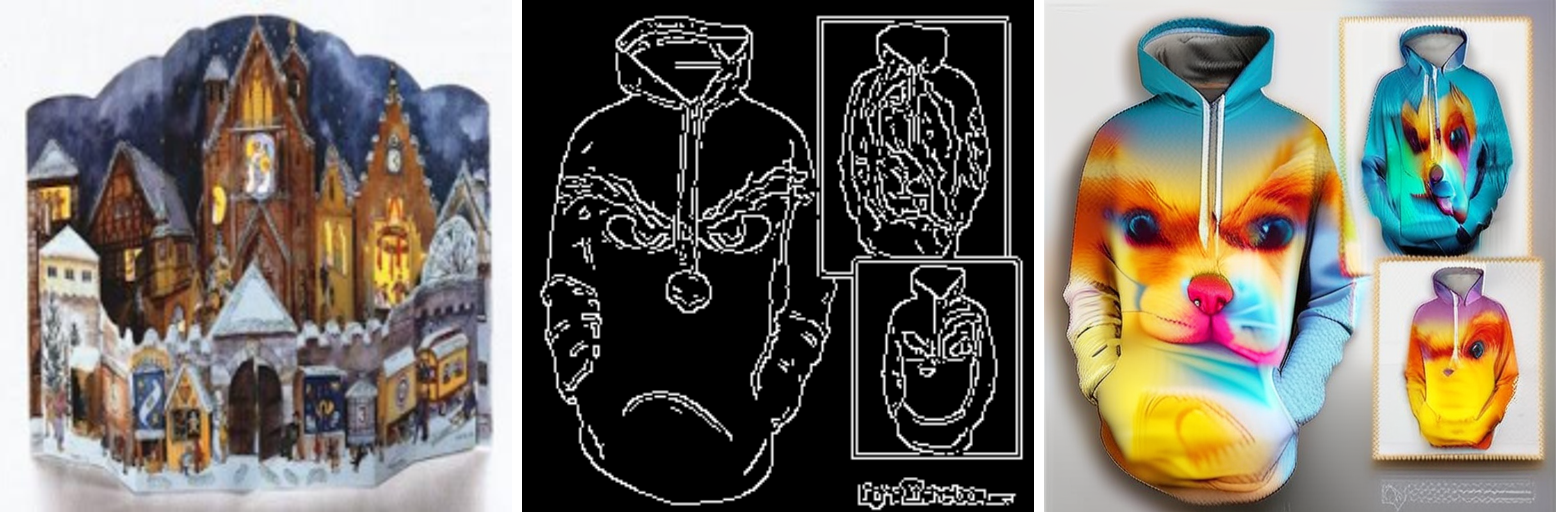


✓ Generation complete!
Best EMD achieved: 0.0112
Attempts made: 10


In [26]:
# Example 2: Dog on hoodie (artistic style)
images2 = generate_from_dataset_id_xl_with_emd(
    colour_index=1008,
    layout_index=33,
    prompt = "a dog on the hoodie, artistic style, professional photography, online store product image",
    target_emd_threshold=0.02,
    max_attempts=20,
    guidance_scale=7.5,
    steps=100,
    controlnet_conditioning_scale=0.9,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.1,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

In [ ]:
# Example 2: Dog on hoodie (artistic style)
images2 = generate_from_dataset_id_xl_with_emd(
    colour_index=1000,
    layout_index=33,
    prompt="a dog on the hoodie, artistic style, professional photography",
    target_emd_threshold=0.02,
    max_attempts=20,
    guidance_scale=7.5,
    steps=50,
    controlnet_conditioning_scale=0.9,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.1,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)